# 準備

In [38]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

#モデル
import lightgbm as lgb

#パラメータ探索
import optuna

#クロスバリデーション
from sklearn.model_selection import KFold
from sklearn.model_selection import GroupKFold

# 評価指標
import sys
sys.path.append('./evaluation')
from rmse import rmse
from recall5 import recall5
from profit import profit

#可視化
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report

#保存
import pickle

In [2]:
#データを読み込む
n_uma_race_df = pd.read_pickle('../datasets/traindata/n_uma_race.pkl')
n_race_df = pd.read_pickle('../datasets/traindata/n_race.pkl')
n_payout_df = pd.read_pickle('../datasets/traindata/n_payout.pkl')

In [3]:
# 新しいグループを作成
n_uma_race_df['group'] = n_uma_race_df['kaisai_nen'].astype(int).astype(str) +"-"+ n_uma_race_df['kaisai_tsukihi'].astype(int).astype(str) +"-"+  n_uma_race_df['keibajo_code'].astype(int).astype(str) +"-"+  n_uma_race_df['race_bango'].astype(int).astype(str)
n_race_df['group'] = n_race_df['kaisai_nen'].astype(int).astype(str) +"-"+ n_race_df['kaisai_tsukihi'].astype(int).astype(str) +"-"+  n_race_df['keibajo_code'].astype(int).astype(str) +"-"+  n_race_df['race_bango'].astype(int).astype(str)
n_payout_df['group'] = n_payout_df['kaisai_nen'].astype(int).astype(str) +"-"+ n_payout_df['kaisai_tsukihi'].astype(int).astype(str) +"-"+  n_payout_df['keibajo_code'].astype(int).astype(str) +"-"+  n_payout_df['race_bango'].astype(int).astype(str)

n_race_df = n_race_df.drop(['kaisai_nen', 'kaisai_tsukihi', 'keibajo_code', 'kaisai_kai', 'kaisai_nichime', 'race_bango'],axis=1)
n_payout_df = n_payout_df.drop(['kaisai_nen', 'kaisai_tsukihi', 'keibajo_code', 'kaisai_kai', 'kaisai_nichime', 'race_bango', 'toroku_tosu', 'shusso_tosu'],axis=1)

merged_df = pd.merge(n_uma_race_df, n_race_df, on='group', how='left')
merged_df = pd.merge(merged_df, n_payout_df, on='group', how='left')
merged_df['group'].nunique()

205318

In [4]:
merged_df['group'].unique()

array(['2023-916-46-1', '2023-916-46-2', '2023-916-46-3', ...,
       '2023-907-50-10', '2023-907-50-11', '2023-907-50-12'], dtype=object)

In [5]:
pd.set_option('display.max_columns', None)
merged_df.head(1)

,kaisai_nen,kaisai_tsukihi,keibajo_code,kaisai_kai,kaisai_nichime,race_bango,wakuban,umaban,ketto_toroku_bango,bamei,umakigo_code,seibetsu_code,hinshu_code,moshoku_code,barei,tozai_shozoku_code,chokyoshi_code,banushi_code,banushimei,futan_juryo,blinker_shiyo_kubun,kishu_code,kishumei_ryakusho,kishu_minarai_code,bataiju,zogen_fugo,zogen_sa,ijo_kubun_code,nyusen_juni,kakutei_chakujun,dochaku_kubun,dochaku_tosu,soha_time,chakusa_code_1,chakusa_code_2,chakusa_code_3,corner_1,corner_2,corner_3,corner_4,tansho_odds,tansho_ninkijun,kakutoku_honshokin,kakutoku_fukashokin,kohan_4f,kohan_3f,aiteuma_joho_1,aiteuma_joho_2,aiteuma_joho_3,time_sa,record_koshin_kubun,kyakushitsu_hantei,group,yobi_code,jusho_kaiji,grade_code,kyoso_shubetsu_code,kyoso_kigo_code,juryo_shubetsu_code,kyoso_joken_code_2sai,kyoso_joken_code_3sai,kyoso_joken_code_4sai,kyoso_joken_code_5sai_ijo,kyoso_joken_code,kyori,track_code,course_kubun,honshokin,fukashokin,hasso_jikoku,toroku_tosu,shusso_tosu,nyusen_tosu,tenko_code,babajotai_code_shiba,babajotai_code_dirt,fuseiritsu_flag_sanrenpuku,tokubarai_flag_sanrenpuku,henkan_flag_sanrenpuku,haraimodoshi_sanrenpuku_1a,haraimodoshi_sanrenpuku_1b,haraimodoshi_sanrenpuku_1c
0,2023,916,46,13,1,1,1,1,2020106227,スターサファイア,0,1,1.0,3,3,3,5319,875800,ＪＰＮ技研,560.0,0,5300,葛山晃平,0,466.0,1,0.0,0,8,8,0,0,1359,4.0,NaN,NaN,9,9,9,9,899,8,0,0,0,411,2020105068フェイマスグローリ,0000000000,0000000000,50,0,0,2023-916-46-1,1,0,0,49,0,4,0,0,0,0,0,1400,24,0,4.000000e+51,0,1140,9,9,9,1,0,1.0,0.0,0.0,0.0,60809.0,210.0,1.0


# 前処理

In [6]:
merged_df['hutan_wariai'] = merged_df['futan_juryo'] / merged_df['bataiju']

In [7]:
def combine_sign_and_diff(row):
    if row['zogen_fugo'] == 2:
        return row['zogen_sa']
    elif row['zogen_fugo'] == 0:
        return -row['zogen_sa']
    else:
        return 0

merged_df['zogen_ryou'] = merged_df.apply(combine_sign_and_diff, axis=1)

In [8]:
merged_df = merged_df[merged_df['ijo_kubun_code'] == 0]
# 1	出走取消	取消	SCRATCHED	S

In [9]:
columns_to_convert = [
                    'kyori',
                    'grade_code',
                    'seibetsu_code',
                    'moshoku_code',
                    'barei',
                    'chokyoshi_code',
                    'banushi_code',
                    'kishu_code',
                    'kishu_minarai_code',
                    'kyoso_shubetsu_code',
                    'juryo_shubetsu_code',
                    'shusso_tosu',
                    'tenko_code',
                    'babajotai_code_dirt',
                    'hutan_wariai',
                    'zogen_ryou',
                    'track_code',
                    'keibajo_code'
                    ]

for column in columns_to_convert:
    merged_df[column].fillna(0, inplace=True)
    try:
        if merged_df[column].astype(float).apply(lambda x: x.is_integer()).all():
            merged_df[column] = merged_df[column].astype(int)
        else:
            merged_df[column] = merged_df[column].astype(float)
    except ValueError:
        merged_df[column] = merged_df[column].astype(float)

    print(f"{column} のデータ型: {merged_df[column].dtype}")

kyori のデータ型: int32
grade_code のデータ型: int32
seibetsu_code のデータ型: int32
moshoku_code のデータ型: int32
barei のデータ型: int32
chokyoshi_code のデータ型: int32
banushi_code のデータ型: int32
kishu_code のデータ型: int32
kishu_minarai_code のデータ型: int32
kyoso_shubetsu_code のデータ型: int32
juryo_shubetsu_code のデータ型: int32
shusso_tosu のデータ型: int32
tenko_code のデータ型: int32
babajotai_code_dirt のデータ型: int32
hutan_wariai のデータ型: float64
zogen_ryou のデータ型: int32
track_code のデータ型: int32
keibajo_code のデータ型: int32


In [10]:
merged_df[column].info()

<class 'pandas.core.series.Series'>
Index: 2017402 entries, 0 to 2042540
Series name: keibajo_code
Non-Null Count    Dtype
--------------    -----
2017402 non-null  int32
dtypes: int32(1)
memory usage: 23.1 MB


In [11]:
def modify_rankings(df, column_name='kakutei_chakujun'):
    """
    この関数はDataFrameの特定の列のランキングを修正します。
    - df: DataFrameオブジェクト
    - column_name: 修正する列の名前（デフォルトは 'kakutei_chakujun'）
    """
    conditions = [
        (df[column_name] == 1),
        (df[column_name] == 2),
        (df[column_name] == 3),
        (df[column_name] == 4),
        (df[column_name] == 5)
    ]
    
    values = [5, 4, 3, 2, 1]
    
    df['target'] = np.select(conditions, values, default=0)
    
    return df

In [12]:
merged_df = modify_rankings(merged_df)

# lightgbm.LGBMRanker

In [13]:
# 2010年から2019年のデータを学習データとして取得
train_data = merged_df[merged_df['kaisai_nen'].isin([2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]

In [14]:
# ランキング学習のために必要な特徴量とターゲットを設定
features = [
            'seibetsu_code',
            'moshoku_code',
            'barei',
            'chokyoshi_code',
            'banushi_code',
            'kishu_code',
            'kishu_minarai_code',
            'kyoso_shubetsu_code',
            'juryo_shubetsu_code',
            'hutan_wariai',
            'zogen_ryou',
            ]

target = 'target'

In [15]:
# ndcgの計算
def ndcg_score(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    
    gain = 2 ** y_true - 1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

def mean_ndcg_score(y_true, y_score, groups, k=5):
    ndcgs = []
    idx_start = 0
    for group in groups:
        ndcgs.append(ndcg_score(y_true[idx_start:idx_start+group], y_score[idx_start:idx_start+group], k))
        idx_start += group
    return np.mean(ndcgs)

In [16]:
# def sigmoid(x):
#     return 1 / (1 + np.exp(-x))

# def lambda_rank_gradient(y_true, y_pred):
#     pred_diff = y_pred[:, None] - y_pred[None, :]
#     true_diff = y_true[:, None] - y_true[None, :]
    
#     S_ij = np.where(true_diff > 0, 1, np.where(true_diff < 0, -1, 0))
    
#     lambda_ij = 0.5 * (1 - S_ij) - sigmoid(-pred_diff)
    
#     grad = np.sum(lambda_ij, axis=1)
    
#     hess = np.sum(sigmoid(pred_diff) * (1 - sigmoid(pred_diff)), axis=1)
#     return grad, hess

# def lambda_rank_gradient_efficient(y_true, y_pred, query_group):
#     grad = np.zeros_like(y_pred)
#     hess = np.zeros_like(y_pred)
    
#     start_idx = 0
#     for group_size in query_group:
#         group_true = y_true[start_idx:start_idx+group_size]
#         group_pred = y_pred[start_idx:start_idx+group_size]
        
#         for i in range(group_size):
#             for j in range(group_size):
#                 if group_true[i] == group_true[j]:
#                     continue
#                 S_ij = 1 if group_true[i] > group_true[j] else -1
#                 pred_diff = group_pred[i] - group_pred[j]
#                 logistic = 1 / (1 + np.exp(S_ij * pred_diff))
#                 grad[i] += S_ij * logistic
#                 hess[i] += logistic * (1 - logistic)
        
#         start_idx += group_size
    
#     return grad, hess

In [17]:
# # 損失関数
# def custom_objective(y_true, y_pred, dataset):
#     if isinstance(y_pred, lgb.basic.Dataset):
#         y_pred = y_pred.get_label()

#     query_group = dataset.get_group()  # クエリのグループサイズを取得
#     grad, hess = lambda_rank_gradient_efficient(np.array(y_true), np.array(y_pred), query_group)

#     top5_indices = np.argsort(y_pred)[-5:]
#     if np.sum(y_true[top5_indices] == 1) == 0:
#         grad[top5_indices] += 1.0 / len(top5_indices)
#     return grad, hess


# # サンプリング
# high_weight_value = 2.0
# sample_weights = np.where(train_data[target] == 1, high_weight_value, 1)

# # 再ランキング
# def rerank_predictions(y_true, y_pred):
#     top5_indices = np.argsort(y_pred)[-5:]
#     if np.sum(y_true[top5_indices] == 1) < 3:
#         one_indices = np.where(y_true == 1)[0]
#         for idx in one_indices:
#             if idx not in top5_indices:
#                 top5_indices[-1] = idx
#                 break
#     return top5_indices

In [18]:
def assign_labels(ranking_data):
    '''
    入賞かどうかを判断するカラム'label'を作成
    
    入賞馬（上位三頭）にラベル1を付与する。それ以外は0を付与するコード
    '''
    ranking_data['label'] = 0
    ranking_data.loc[ranking_data['kakutei_chakujun'] <= 3, 'label'] = 1

In [19]:
assign_labels(merged_df)

In [20]:
# サンプリング
'''
'label'に応じて、sample_weightsを変更するコード

入賞馬のデータをそれ以外のもの2倍多くサンプリングしやすいように重みを変更する
'''
y_true = merged_df['label'].values
sample_weights = np.where(y_true == 1, 2.0, 1.0)

In [21]:
# カスタム損失関数
PENALTY_TERM = 1

def custom_loss(y_pred, train_data):
    '''
    勾配にペナルティーを付けるコード

    予測の上位5頭の内に実際の入賞馬がいないと勾配を大きくする
    勾配が大きいほどパラメータの更新量も大きくなるので
    '''
    y_true = train_data['label'].values
    grad = 2 * (y_pred - y_true)
    hess = 2 * np.ones_like(y_true)
    
    top5_indices = np.argsort(y_pred)[-5:]
    if np.sum(y_true[top5_indices] == 1) == 0:
        grad[top5_indices] += PENALTY_TERM
    return grad, hess

In [22]:
# 再ランキング
def rerank_predictions(y_true, y_pred):
    '''
    
    '''
    top5_indices = np.argsort(y_pred)[-5:]
    if np.sum(y_true[top5_indices] == 1) < 3:
        one_indices = np.where(y_true == 1)[0]
        for idx in one_indices:
            if idx not in top5_indices:
                top5_indices[-1] = idx
                break
    return top5_indices

In [23]:
# import numpy as np

# # Assign labels to the items based on their ranks
# def assign_labels(ranking_data):
#     ranking_data['label'] = 0
#     ranking_data.loc[ranking_data['rank'] <= 3, 'label'] = 1

# # Custom loss function with penalty term
# def custom_loss(y_pred, train_data):
#     y_true = train_data.get_label()
#     grad = 2 * (y_pred - y_true)  # Gradient calculation
#     hess = 2 * np.ones_like(y_true)  # Hessian calculation
    
#     # Get top 5 indices
#     top5_indices = np.argsort(y_pred)[-5:]
    
#     # If none of the top 5 predictions are correct, apply penalty
#     if np.sum(y_true[top5_indices] == 1) == 0:
#         grad[top5_indices] += PENALTY_TERM
    
#     return grad, hess

# HIGH_WEIGHT = 2.0
# LOW_WEIGHT = 1.0

# y_true = train_data[target].values
# sample_weights = np.where(y_true == 1, HIGH_WEIGHT, LOW_WEIGHT)

# # custom_loss function
# PENALTY_TERM = 1  # adjust this based on your needs

# # Re-ranking strategy
# def rerank_predictions(y_true, y_pred):
#     top5_indices = np.argsort(y_pred)[-5:]
#     if np.sum(y_true[top5_indices] == 1) < 3:
#         one_indices = np.where(y_true == 1)[0]
#         for idx in one_indices:
#             if idx not in top5_indices:
#                 top5_indices[-1] = idx
#                 break
#     return top5_indices

# # You can then incorporate these functions into your model training and evaluation code.


In [24]:
group_sizes = train_data.groupby('group').size()

def objective(trial):
    # Optuna parameters
    params = {
        'objective': None,
        'metric': 'ndcg',
        # 'ndcg_at': 5,
        # 'ndcg_eval_at': 5,
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'verbose': trial.suggest_int('verbose', 0, 1),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-5, 10.0, log=True),  # L1正則化
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-5, 10.0, log=True)  # L2正則化
    }
    
    gkf = GroupKFold(n_splits=5)
    ndcgs = []
    
    for train_index, valid_index in gkf.split(train_data, groups=train_data['group']):
        train_fold_data = train_data.iloc[train_index]
        valid_fold_data = train_data.iloc[valid_index]
    
        train_fold_group_sizes = train_fold_data.groupby('group').size().tolist()
        valid_fold_group_sizes = valid_fold_data.groupby('group').size().tolist()
    
        train_dataset = lgb.Dataset(train_fold_data[features], 
                                   label=train_fold_data[target], 
                                   group=train_fold_group_sizes, 
                                   weight=sample_weights[train_index]) # sample_weightsからウェイトを取得
    
        valid_dataset = lgb.Dataset(valid_fold_data[features], 
                                   label=valid_fold_data[target], 
                                   group=valid_fold_group_sizes, 
                                   reference=train_dataset)

        ranker = lgb.train(
            params,
            train_dataset,
            valid_sets=[valid_dataset],
            evals_result={},
            num_boost_round=1000,
            early_stopping_rounds=100,
            verbose_eval=10,
            fobj=custom_loss
        )
        
        y_pred = ranker.predict(valid_fold_data[features])
        top5_indices = rerank_predictions(valid_fold_data[target].values, y_pred)
        ndcg_value = mean_ndcg_score(valid_fold_data[target].values[top5_indices], y_pred[top5_indices], valid_fold_group_sizes)
        ndcgs.append(ndcg_value)
    
    return np.mean(ndcgs)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

[I 2023-10-19 10:28:03,847] A new study created in memory with name: no-name-efcc0cf5-ea55-40ef-bf33-eaea03ba2969


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011045 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[10]	valid_0's ndcg@1: 0.384614	valid_0's ndcg@2: 0.427865	valid_0's ndcg@3: 0.47831	valid_0's ndcg@4: 0.526046	valid_0's ndcg@5: 0.56863
[20]	valid_0's ndcg@1: 0.39093	valid_0's ndcg@2: 0.433972	valid_0's ndcg@3: 0.483887	valid_0's ndcg@4: 0.531866	valid_0's ndcg@5: 0.573775
[30]	valid_0's ndcg@1: 0.39392	valid_0's ndcg@2: 0.436026	valid_0's ndcg@3: 0.486989	valid_0's ndcg@4: 0.533596	valid_0's ndcg@5: 0.575885
[40]	valid_0's ndcg@1: 0.393904	valid_0's ndcg@2: 0.437551	valid_0's ndcg@3: 0.48837	valid_0's ndcg@4: 0.534562	valid_0's ndcg@5: 0.577127
[50]	valid_0's ndcg@1: 0.396981	vali

[I 2023-10-19 11:05:39,893] Trial 0 finished with value: 0.0018231341729392375 and parameters: {'num_leaves': 223, 'learning_rate': 0.032171234403397385, 'feature_fraction': 0.41251040334731903, 'bagging_freq': 8, 'verbose': 0, 'lambda_l1': 0.000639194381704188, 'lambda_l2': 2.5875432126283187}. Best is trial 0 with value: 0.0018231341729392375.


[LightGBM] [Info] Loading query weights...
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1169
[LightGBM] [Info] Number of data points in the train set: 1168488, number of used features: 11
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[10]	valid_0's ndcg@1: 0.384787	valid_0's ndcg@2: 0.426258	valid_0's ndcg@3: 0.478213	valid_0's ndcg@4: 0.525532	valid_0's ndcg@5: 0.567902
[20]	valid_0's ndcg@1: 0.391095	valid_0's ndcg@2: 0.434055	valid_0's ndcg@3: 0.485099	valid_0's ndcg@4: 0.532262	valid_0's ndcg@5: 0.574281
[30]	valid_0's ndcg@1: 0.395604	valid_0's ndcg@2: 0.43805	valid_0's ndcg@3: 0.489152	valid_0's ndcg@4: 0.535494	valid_0's ndcg@5: 0.577978


[I 2023-10-19 11:32:08,406] Trial 1 finished with value: 0.001917478903814735 and parameters: {'num_leaves': 184, 'learning_rate': 0.06738722323428348, 'feature_fraction': 0.498351191381617, 'bagging_freq': 1, 'verbose': 1, 'lambda_l1': 1.3373675994482691e-05, 'lambda_l2': 0.0011429357433726018}. Best is trial 1 with value: 0.001917478903814735.


[LightGBM] [Info] Loading query weights...
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1169
[LightGBM] [Info] Number of data points in the train set: 1168488, number of used features: 11
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[10]	valid_0's ndcg@1: 0.37966	valid_0's ndcg@2: 0.422371	valid_0's ndcg@3: 0.473773	valid_0's ndcg@4: 0.520147	valid_0's ndcg@5: 0.563515
[20]	valid_0's ndcg@1: 0.382674	valid_0's ndcg@2: 0.425078	valid_0's ndcg@3: 0.47628	valid_0's ndcg@4: 0.523124	valid_0's ndcg@5: 0.565794
[30]	valid_0's ndcg@1: 0.382749	valid_0's ndcg@2: 0.425675	valid_0's ndcg@3: 0.476325	valid_0's ndcg@4: 0.523244	valid_0's ndcg@5: 0.566606
[

[I 2023-10-19 11:45:45,187] Trial 2 finished with value: 0.001522446871265308 and parameters: {'num_leaves': 134, 'learning_rate': 0.0021502942078280517, 'feature_fraction': 0.42714212123809575, 'bagging_freq': 9, 'verbose': 1, 'lambda_l1': 0.00021489380874056263, 'lambda_l2': 2.2745157531043523}. Best is trial 1 with value: 0.001917478903814735.


In [25]:
# 最適なパラメータ
best_params = study.best_params

# KFoldでのモデル訓練
kf = KFold(n_splits=5, shuffle=True, random_state=42)
models = []

for train_index, valid_index in kf.split(train_data):
    train_fold_data = train_data.iloc[train_index]
    valid_fold_data = train_data.iloc[valid_index]
    
    train_fold_group_sizes = train_fold_data.groupby('group').size().tolist()
    valid_fold_group_sizes = valid_fold_data.groupby('group').size().tolist()
    
    ranker = lgb.LGBMRanker(**best_params)
    ranker.fit(
        train_fold_data[features], train_fold_data[target], 
        group=train_fold_group_sizes, 
        eval_set=[(valid_fold_data[features], valid_fold_data[target])], 
        eval_group=[valid_fold_group_sizes], 
        eval_at=5, early_stopping_rounds=20, verbose=10
    )
    models.append(ranker)

[LightGBM] [Warning] feature_fraction is set=0.498351191381617, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.498351191381617
[LightGBM] [Warning] lambda_l1 is set=1.3373675994482691e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3373675994482691e-05
[LightGBM] [Warning] lambda_l2 is set=0.0011429357433726018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011429357433726018
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.498351191381617, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.498351191381617
[LightGBM] [Warning] lambda_l1 is set=1.3373675994482691e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3373675994482691e-05
[LightGBM] [Warning] lambda_l2 is set=0.0011429357433726018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011429357433726018
[LightGBM] [Warning] baggi

### テストデータで予測

In [26]:
# 2020年から2022年のテストデータを取得
test_data_2020 = merged_df[merged_df['kaisai_nen'] == 2020].copy()
test_data_2021 = merged_df[merged_df['kaisai_nen'] == 2021].copy()
test_data_2022 = merged_df[merged_df['kaisai_nen'] == 2022].copy()

# 2021年と2022年のデータに対して予測を行い、平均を取る
test_data_2020.loc[:, 'y_pred'] = sum([model.predict(test_data_2020[features], num_iteration=model.best_iteration_) for model in models]) / len(models)
test_data_2021.loc[:, 'y_pred'] = sum([model.predict(test_data_2021[features], num_iteration=model.best_iteration_) for model in models]) / len(models)
test_data_2022.loc[:, 'y_pred'] = sum([model.predict(test_data_2022[features], num_iteration=model.best_iteration_) for model in models]) / len(models)

# 予測されたランクをグループごとに計算
test_data_2020.loc[:, 'predicted_rank'] = test_data_2020.groupby('group')['y_pred'].rank(ascending=False,method='min')
test_data_2021.loc[:, 'predicted_rank'] = test_data_2021.groupby('group')['y_pred'].rank(ascending=False,method='min')
test_data_2022.loc[:, 'predicted_rank'] = test_data_2022.groupby('group')['y_pred'].rank(ascending=False,method='min')

# 結果を表示
test_data_2021[['group', 'predicted_rank', 'kakutei_chakujun']]

,group,predicted_rank,kakutei_chakujun
1635601,2021-222-83-2,6.0,6
1635602,2021-222-83-2,2.0,7
1635603,2021-222-83-2,9.0,1
1635604,2021-222-83-2,4.0,2
1635605,2021-101-45-1,6.0,1
...,...,...,...
1785604,2021-1231-54-11,11.0,3
1785605,2021-1231-54-11,7.0,1
1785606,2021-1231-54-11,5.0,2
1785607,2021-1231-54-11,2.0,11


## モデル評価

In [27]:
test_datas = [test_data_2020, test_data_2021, test_data_2022]
years = [2020, 2021, 2022]

In [28]:
rmse(test_datas, years)

RMSE for 2020: 3.643
RMSE for 2021: 3.710
RMSE for 2022: 3.694
Mean RMSE: 3.682


In [29]:
recall5(test_datas, years)

2020 Precision@5: 38.428%
2020 Recall@5: 64.047%
2021 Precision@5: 38.060%
2021 Recall@5: 63.433%
2022 Precision@5: 38.150%
2022 Recall@5: 63.583%
Average Precision@5: 38.213%
Average Recall@5: 63.688%


In [39]:
profit(test_datas, years)

2020 Average Net Profit: -636.307 yen
2021 Average Net Profit: -588.720 yen
2022 Average Net Profit: -611.034 yen
Mean Average Net Profit: -612.020 yen


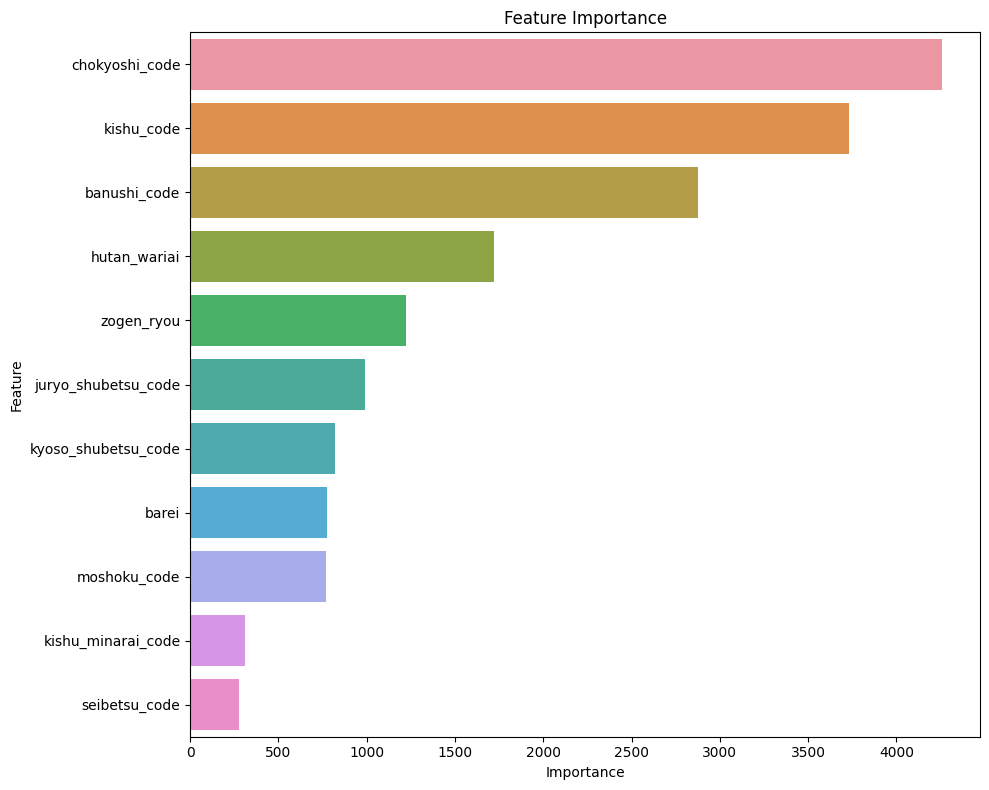

In [31]:
# models[0]'s feature importances
feature_importance = models[0].feature_importances_

# Convert feature names and importances to DataFrame
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# モデル保存

In [32]:
# 学習
full_train_dataset = lgb.Dataset(merged_df[features], label=merged_df[target])
full_model = lgb.train(best_params, full_train_dataset, num_boost_round=500, verbose_eval=100)  # ここではvalid_setsやearly_stopping_roundsは使用しない

# モデルを保存
# model_save_path = '../app/models/model.pkl'
model_save_path = './bestmodels/lightgbmranker.pkl'
with open(model_save_path, 'wb') as f:
    pickle.dump(full_model, f)

print(f"Model saved to {model_save_path}")

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013514 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1172
[LightGBM] [Info] Number of data points in the train set: 2017402, number of used features: 11
[LightGBM] [Info] Start training from score 1.514390
Model saved to ./bestmodels/lightgbmranker.pkl


In [33]:
merged_df.loc[:, 'y_pred'] = sum([model.predict(merged_df[features], num_iteration=model.best_iteration_) for model in models]) / len(models)
merged_df.loc[:, 'predicted_rank'] = merged_df.groupby('group')['y_pred'].rank(ascending=False, method='min')

In [34]:
train_data_2010 = merged_df[merged_df['kaisai_nen'] == 2010].copy()
train_data_2011 = merged_df[merged_df['kaisai_nen'] == 2011].copy()
train_data_2012 = merged_df[merged_df['kaisai_nen'] == 2012].copy()
train_data_2013 = merged_df[merged_df['kaisai_nen'] == 2013].copy()
train_data_2014 = merged_df[merged_df['kaisai_nen'] == 2014].copy()
train_data_2015 = merged_df[merged_df['kaisai_nen'] == 2015].copy()
train_data_2016 = merged_df[merged_df['kaisai_nen'] == 2016].copy()
train_data_2017 = merged_df[merged_df['kaisai_nen'] == 2017].copy()
train_data_2018 = merged_df[merged_df['kaisai_nen'] == 2018].copy()
train_data_2019 = merged_df[merged_df['kaisai_nen'] == 2019].copy()
train_datas = [train_data_2010, train_data_2011, train_data_2012, train_data_2013, train_data_2014, train_data_2015, train_data_2016, train_data_2017, train_data_2018, train_data_2019]
t_years = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

In [35]:
rmse(train_datas, t_years)

RMSE for 2010: 3.433
RMSE for 2011: 3.417
RMSE for 2012: 3.392
RMSE for 2013: 3.465
RMSE for 2014: 3.491
RMSE for 2015: 3.377
RMSE for 2016: 3.390
RMSE for 2017: 3.420
RMSE for 2018: 3.483
RMSE for 2019: 3.518
Mean RMSE: 3.439


In [36]:
recall5(train_datas, t_years)

2010 Precision@5: 40.606%
2010 Recall@5: 67.676%
2011 Precision@5: 41.382%
2011 Recall@5: 68.970%
2012 Precision@5: 41.173%
2012 Recall@5: 68.621%
2013 Precision@5: 40.553%
2013 Recall@5: 67.588%
2014 Precision@5: 40.692%
2014 Recall@5: 67.819%
2015 Precision@5: 41.291%
2015 Recall@5: 68.818%
2016 Precision@5: 41.351%
2016 Recall@5: 68.918%
2017 Precision@5: 40.959%
2017 Recall@5: 68.265%
2018 Precision@5: 40.729%
2018 Recall@5: 67.881%
2019 Precision@5: 39.681%
2019 Recall@5: 66.135%
Average Precision@5: 40.842%
Average Recall@5: 68.069%


In [40]:
profit(train_datas, t_years)

2010 Average Net Profit: -787.292 yen
2011 Average Net Profit: -672.390 yen
2012 Average Net Profit: -733.145 yen
2013 Average Net Profit: -631.591 yen
2014 Average Net Profit: -772.137 yen
2015 Average Net Profit: -687.661 yen
2016 Average Net Profit: -752.979 yen
2017 Average Net Profit: -772.722 yen
2018 Average Net Profit: -687.512 yen
2019 Average Net Profit: -739.272 yen
Mean Average Net Profit: -723.670 yen


In [41]:
def check_top3_in_top5_predictions(group):
    predicted_top5 = group.nsmallest(5, 'predicted_rank').index.tolist()
    actual_top3 = group.nsmallest(3, 'kakutei_chakujun').index.tolist()
    return all([horse in predicted_top5 for horse in actual_top3])

def calculate_group_profit(group):
    if check_top3_in_top5_predictions(group):
        payout_value = group['haraimodoshi_sanrenpuku_1b'].iloc[0]
        return payout_value - 1000
    else:
        return -1000

def profit(test_datas, years):
    """
    profitを計算する
    
    Parameters:
    - test_datas: リスト。それぞれの年のテストデータのデータフレームを含む
    - years: 計算する年数のリスト
    """
    mean_profits = []

    for test_data, year in zip(test_datas, years):
        profit_df = test_data.groupby('group').apply(calculate_group_profit).reset_index(name='profit')
        total_profit = profit_df['profit'].sum()
        average_net_profit = total_profit / len(profit_df)
        
        print(f"{year} Average Net Profit: {average_net_profit:.3f} yen")
        mean_profits.append(average_net_profit)
    
    print(f"Mean Average Net Profit: {np.mean(mean_profits):.3f} yen")

In [42]:
profit(test_datas, years)

2020 Average Net Profit: -306.157 yen
2021 Average Net Profit: -370.463 yen
2022 Average Net Profit: -337.259 yen
Mean Average Net Profit: -337.960 yen


In [43]:
profit(train_datas, t_years)

2010 Average Net Profit: -287.124 yen
2011 Average Net Profit: -224.373 yen
2012 Average Net Profit: -182.016 yen
2013 Average Net Profit: -212.917 yen
2014 Average Net Profit: -334.329 yen
2015 Average Net Profit: -267.603 yen
2016 Average Net Profit: -234.374 yen
2017 Average Net Profit: -274.244 yen
2018 Average Net Profit: -254.118 yen
2019 Average Net Profit: -247.618 yen
Mean Average Net Profit: -251.872 yen
